In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

In [5]:
import json
import datetime

import numpy as np
import pandas as pd

In [6]:
# - Who had the largest increase in followers
# - what were the most shared hashtags?
# - who were the most retweeted users?
# - who were the most mentioned users?
# - what was the most shared link?

In [7]:
time_format = "%a %b %d %H:%M:%S +0000 %Y"

In [8]:
def str_to_json(json_str):    
    try:
        tweet = json.loads(json_str)
        return tweet
    except ValueError as ve:
        return None
    
def tweet_to_hashtag(tweet):
    return [(ht["text"].lower(), 1) for ht in tweet["entities"]["hashtags"]]

def t_to_d(t):
    return datetime.datetime.strptime(t["created_at"], time_format)

def tweet_to_entity(tweet, entity, field="text"):
    return [(ht[field], 1) for ht in tweet["entities"][entity]]

def delta_followers(l):
    sorted_samples = sorted(l, key=lambda x: x[0])
    first_sample = sorted_samples[0][1]
    last_sample = sorted_samples[-1][1]
    
    diff = last_sample - first_sample
    return (diff / (first_sample + 1), diff)

#################### Tweet Count ####################
82745
#################### Most Used Hashtags ####################
('glfbonn2017', 4072)
('oneplanet', 2987)
('climatechange', 2293)
('thinklandscape', 2048)
('rallyforrivers', 1306)
('climateaction', 1216)
('saveshefftrees', 892)
('climate', 697)
('oil', 690)
('forestry', 658)
('parisagreement', 643)
('forests', 641)
('sheffield', 637)
('forest', 629)
('oneplanetsummit', 622)
('gas', 621)
('breakingnews', 532)
('restoration', 474)
('cop23', 440)
('bonn', 401)
#################### Most Shared URLs ####################
('http://bit.ly/2B0zYaZ', 447)
('http://wrld.bg/k8Kw30haI5K', 339)
('http://bit.ly/2oI8KjU', 173)
('http://bit.ly/2BFwXtV', 158)
('http://wrld.bg/rpne30haHL0', 154)
('http://cleanseas.org/commit', 127)
('http://cleanseas.org/', 94)
('http://bit.ly/2zvqjno', 75)
('http://bit.ly/2fKjPgz', 67)
('http://bit.ly/2AP7IFm', 62)
('http://bit.ly/2p9ZsxA', 57)
('http://bit.ly/2oYf9re', 56)
('http://bit.ly/2o8Gtmy', 56)
('http://b

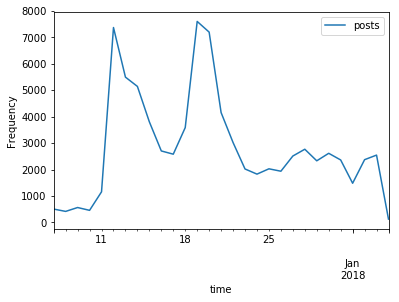

In [6]:
local_map = {}

# rdd = sc.textFile("/scratch/clb617/data/wri/wri_2018/data/community_filtered.json.gz")
rdd = sc.textFile("wri/2017_community_filtered")
tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
tweets = tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1]).cache()

print("#" * 20, "Tweet Count", "#" * 20)
count = tweets.count()
print(count)
local_map["count"] = count

hashtags = tweets.flatMap(tweet_to_hashtag).reduceByKey(lambda x, y: x+y)
hashtags_ = hashtags.collect()
hashtags_sorted = sorted(hashtags_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Used Hashtags", "#" * 20)
for ht in hashtags_sorted[:20]:
    print(ht)
local_map["hashtags"] = hashtags_sorted


entities = tweets.flatMap(lambda x: tweet_to_entity(x, "urls", "expanded_url")).reduceByKey(lambda x, y: x+y)
entities_ = entities.collect()
entities_sorted = sorted(entities_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Shared URLs", "#" * 20)
for e in entities_sorted[:20]:
    print(e)
local_map["urls"] = entities_sorted

entities = tweets.flatMap(lambda x: tweet_to_entity(x, "user_mentions", "screen_name")).map(lambda x: (x[0].lower(), x[1])).reduceByKey(lambda x, y: x+y)
entities_ = entities.collect()
entities_sorted = sorted(entities_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Mentioned", "#" * 20)
for e in entities_sorted[:20]:
    print(e)
local_map["mentions"] = entities_sorted

retweeted_users = tweets.filter(lambda t: "retweeted_status" in t).\
    map(lambda t: t["retweeted_status"]).\
    map(lambda t: (t["user"]["screen_name"].lower(), 1))
retweeted_users_ = retweeted_users.reduceByKey(lambda x, y: x + y).collect()
retweeted_users_sorted = sorted(retweeted_users_, key=lambda x: x[1], reverse=True)
print("#" * 20, "Most Retweeted", "#" * 20)
for e in retweeted_users_sorted[:20]:
    print(e)
local_map["retweet"] = retweeted_users_sorted

users = tweets.map(lambda t: (t["user"]["screen_name"], [(t_to_d(t), t["user"]["followers_count"])]))
user_followers = users.reduceByKey(lambda l, r: l + r).mapValues(delta_followers).collect()
user_followers_sorted = sorted(user_followers, key=lambda x: x[1][0], reverse=True)
print("#" * 20, "Greatest Follower Gain by Multiple", "#" * 20)
for e in user_followers_sorted[:20]:
    print(e)
local_map["followers"] = user_followers

user_followers_sorted = sorted(user_followers, key=lambda x: x[1][1], reverse=True)
print("#" * 20, "Greatest Follower Gain by Volume", "#" * 20)
for e in user_followers_sorted[:20]:
    print(e)

post_times = tweets.map(lambda t: (t_to_d(t), 1)).reduceByKey(lambda l, r: l+r).collect()
df = pd.DataFrame(post_times, columns=["time", "posts"])
df.index = df.time
df.resample("D").sum().plot()
plt.ylabel("Frequency")
plt.show()

local_map["temporal"] = df



In [7]:
# tgs = ["ethiopialiveupd", "idziedzorm", "mgavner2", "gnbug1", "colonjuwonilo", "p2pafghanistan", "annabel04163592", "musaotienoongao", "zenhuman", "collect86", "30x30ffl", "afdb_group", "_africanunion", "olumideidowu"]
tgs = [
    # GLF Social Media Toolkit Users
    "aguribfakim",
    "asteiner",
    "bmub",
    "bmz_bund",
    "cgiar_data",
    "charlesbatte",
    "ciat_",
    "cifor",
    "envirogov",
    "faoforestry",
    "forestideas",
    "forestsmatter",
    "fta_cgiar",
    "giz",
    "globallf",
    "globallf_fr",
    "globallf_id",
    "icraf",
    "ifsadotnet",
    "iki_bmub",
    "iucn",
    "iufro",
    "jattali",
    "nepad_agency",
    "rare_org",
    "sadhgurujv",
    "scottfrog",
    "sianiagri",
    "terraafrica",
    "unccd",
    "unep",
    "wbg_climate",
    "welltoldstory_",
    "wle_cgiar",
    "worldresources",
    "wur",
    "wwf",

    # Greatest follower gain
    "cgtnofficial",
    "globallf_esp",
    "pdchina",
    
    # Others of interest
    "biancajagger", 
    "sadhgurujv", 
    "iluvco2",
]
target_users = {x:None for x in tgs}

for target_user in target_users.keys():
    timed_followers = tweets.filter(lambda t: t["user"]["screen_name"].lower() == target_user).\
        map(lambda t: (datetime.datetime.strptime(t["created_at"], time_format), t["user"]["followers_count"])).\
        collect()
        
    target_users[target_user] = timed_followers

In [8]:
target_users_df = {}

for target_user, timed_followers in target_users.items():
    df = pd.DataFrame(timed_followers, columns=["time", "followers"])
    df.index = pd.to_datetime(df.time)
    
    target_users_df[target_user] = df

In [9]:
dfs = [df.drop_duplicates().resample("D").pad().rename(columns={"followers": u}) for u, df in target_users_df.items()]

In [10]:
first = None
for df in dfs:
    if ( first is None ):
        first = df.copy()
    else:
        first = first.join(df[df.columns[1]], how="outer")

In [11]:
left = None
for df in dfs:
    if ( left is None ):
        left = df
    else:
        left = left.join(df, rsuffix="_", how="outer")
        
for u in target_users_df.keys():
    left[u + "_norm"] = (left[u] - left[u].min()) / (left[u].max() - left[u].min())

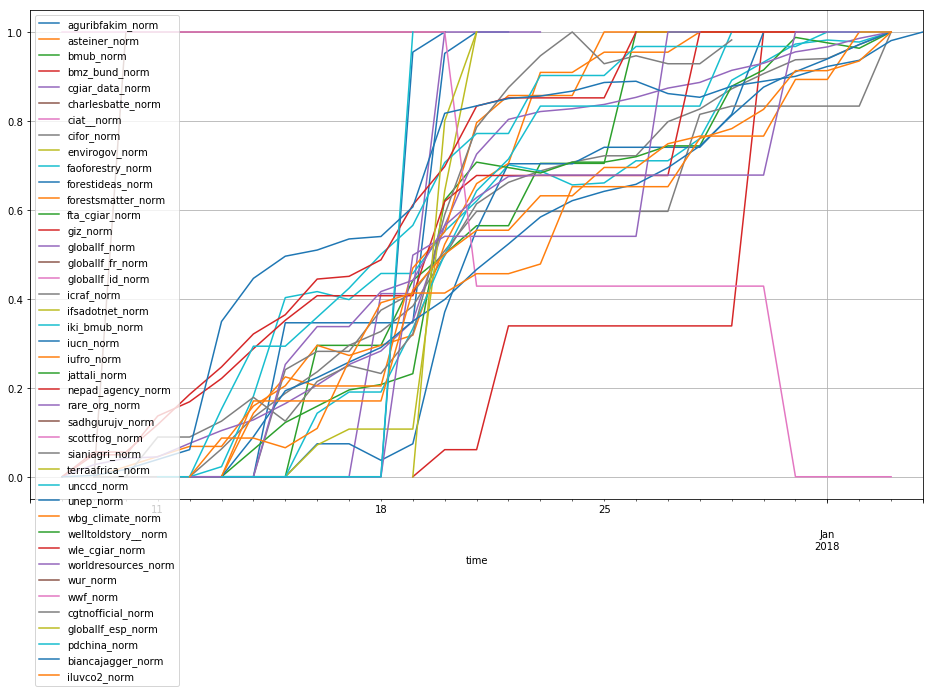

In [12]:
fig = plt.figure(figsize=(16,9))

ax = plt.subplot(1,1, 1)
left[[x + "_norm" for x in target_users.keys()]].plot(ax=ax)
# left["olumideidowu"].plot(ax=ax)

# ax.set_yscale("log")

plt.grid()
plt.show()

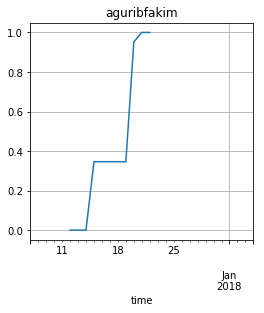

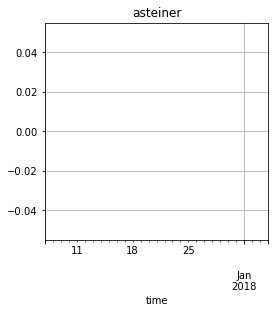

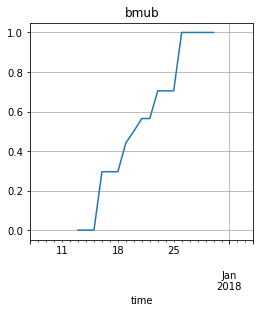

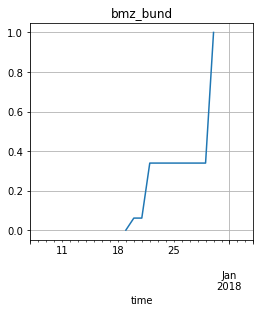

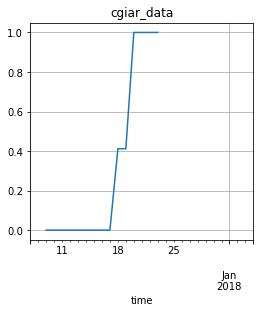

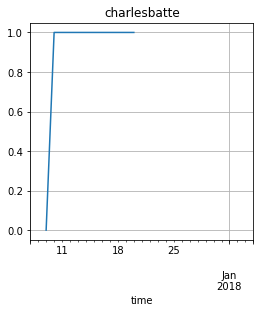

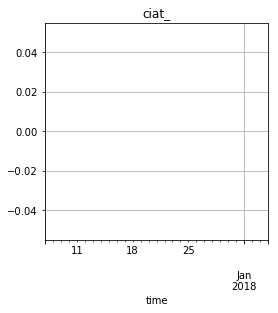

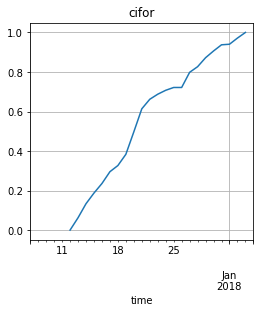

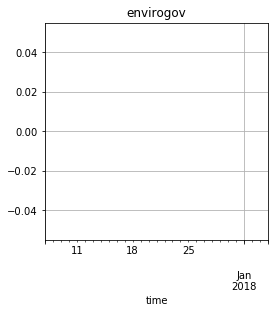

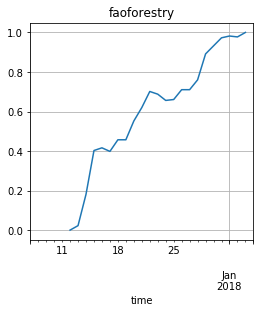

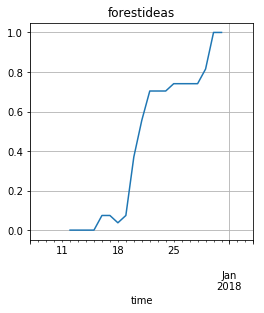

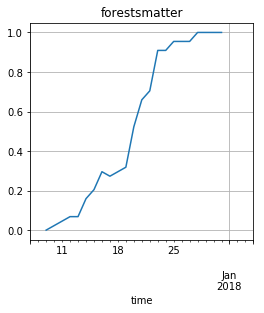

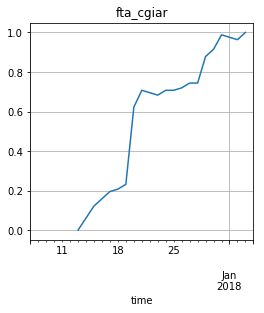

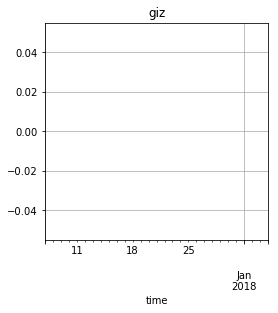

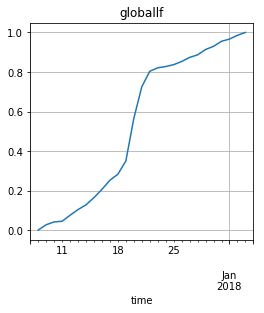

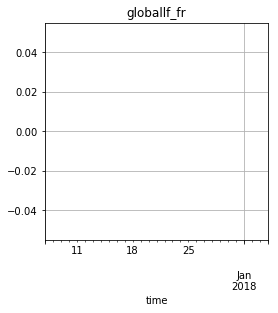

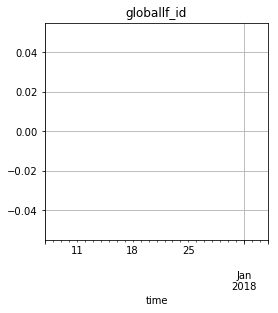

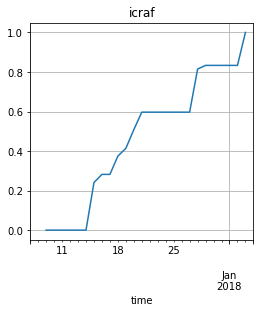

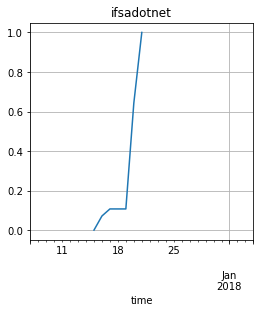

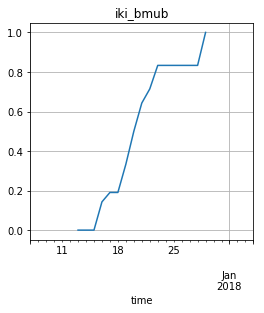

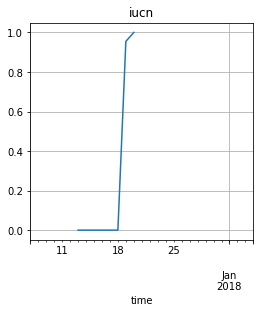

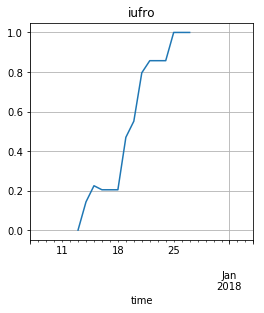

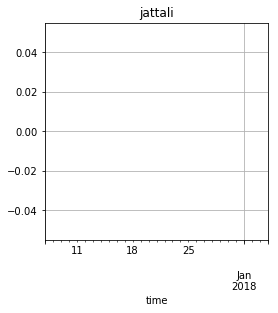

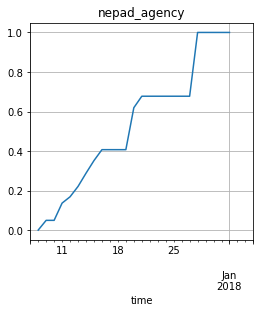

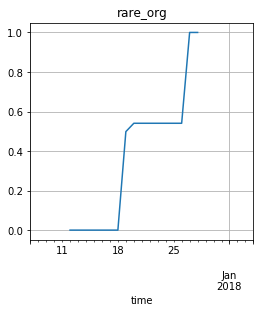

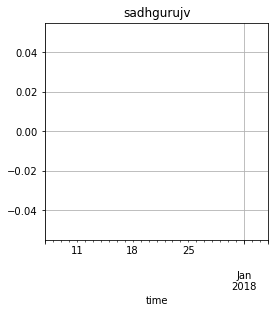

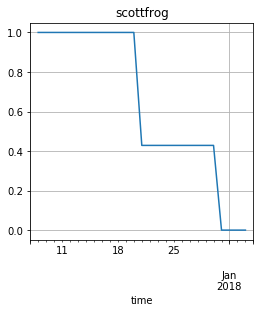

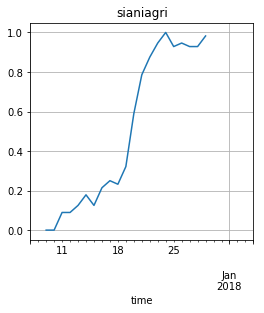

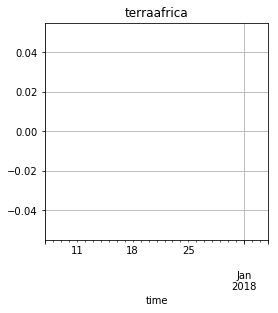

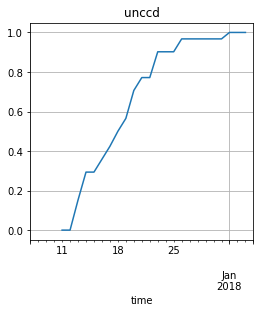

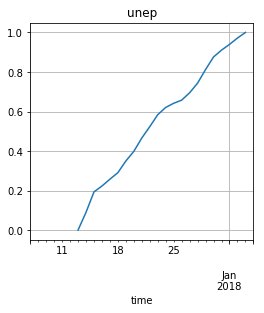

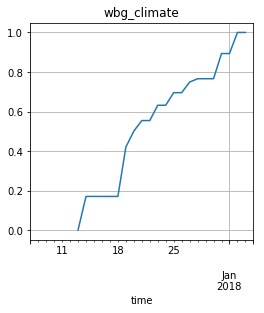

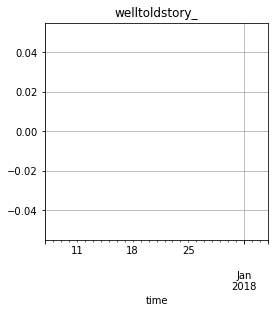

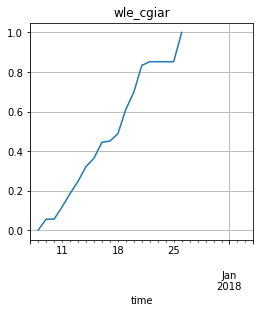

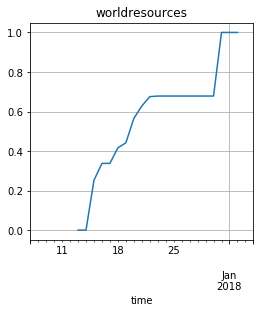

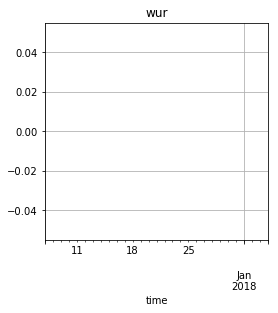

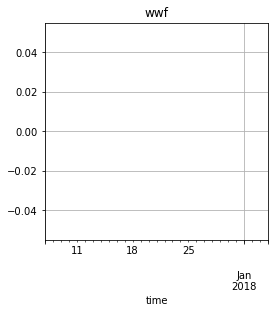

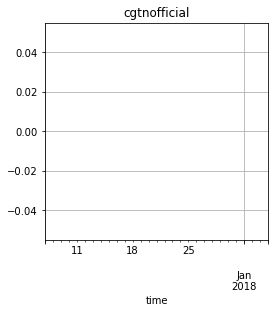

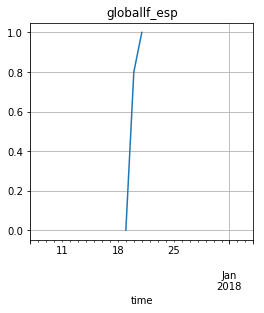

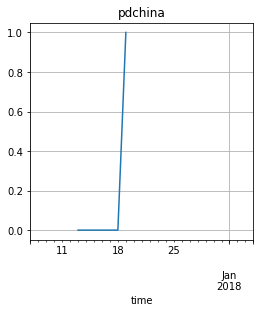

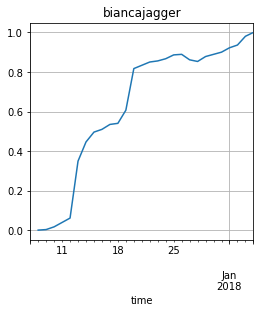

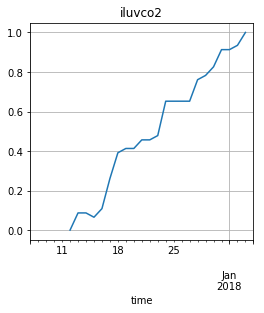

In [13]:
for u in target_users.keys():
    fig = plt.figure(figsize=(4,4))

    ax = plt.subplot(1,1, 1)
    left[u + "_norm"].plot(ax=ax)
    # left["olumideidowu"].plot(ax=ax)

    # ax.set_yscale("log")

    plt.title(u)
    plt.grid()
    plt.show()

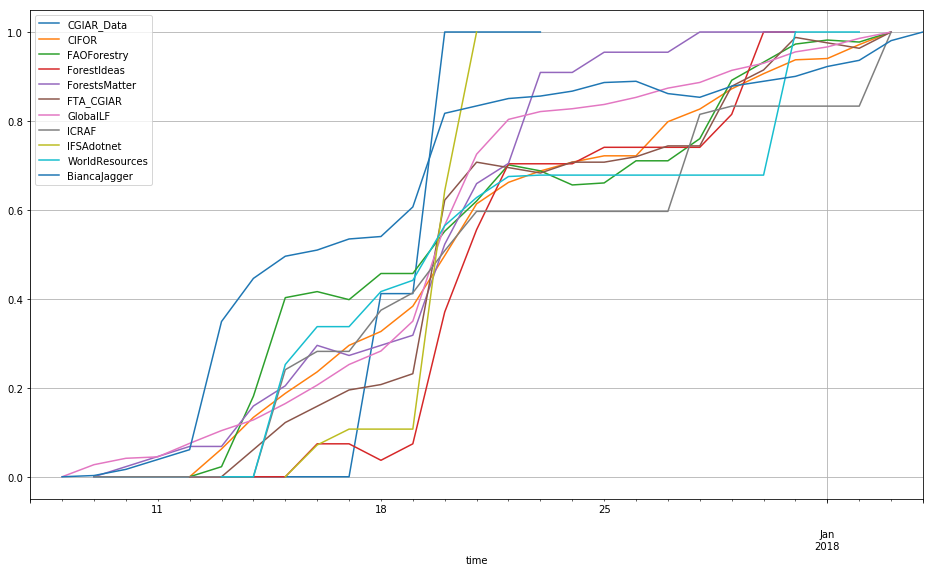

In [15]:
plot_targets = [
"cgiar_data",
"cifor",
"faoforestry",
"forestideas",
"forestsmatter",
"fta_cgiar",
"globallf",
"icraf",
"ifsadotnet",
"worldresources",
"biancajagger",
]

fig = plt.figure(figsize=(16,9))

ax = plt.subplot(1,1, 1)
left[[x + "_norm" for x in plot_targets]].rename(columns={
    "cgiar_data_norm": "CGIAR_Data",
    "cifor_norm": "CIFOR",
    "faoforestry_norm": "FAOForestry",
    "forestideas_norm": "ForestIdeas",
    "forestsmatter_norm": "ForestsMatter",
    "fta_cgiar_norm": "FTA_CGIAR",
    "globallf_norm": "GlobalLF",
    "icraf_norm": "ICRAF",
    "ifsadotnet_norm": "IFSAdotnet",
    "worldresources_norm": "WorldResources",
    "biancajagger_norm": "BiancaJagger",
}).plot(ax=ax)
# left["olumideidowu"].plot(ax=ax)

# ax.set_yscale("log")

plt.grid()
plt.show()

In [ ]:
first["fta_cgiar"].plot()

In [ ]:
left["fta_cgiar_norm"].plot()

In [9]:
rdd = sc.textFile("wri/2017/0*/*.gz")
all_tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
all_tweets = all_tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1]).cache()
all_tweets_count = all_tweets.count()

In [10]:
all_tweets_count

473729

In [11]:
dates = all_tweets.map(lambda t: (t_to_d(t), 1)).reduceByKey(lambda l,r: l+r).collect()
date_df = pd.DataFrame(dates, columns=["date", "count"])
date_df.index = date_df.date

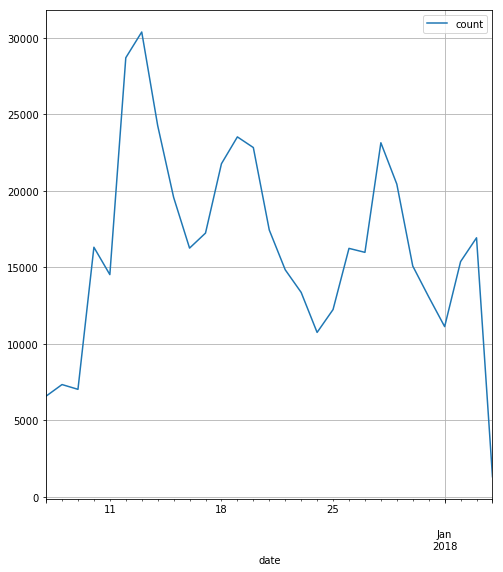

In [12]:
fig = plt.figure(figsize=(8, 9))
ax = fig.add_subplot(1,1,1)
date_df.resample("D").sum().plot(ax=ax)

plt.grid()
plt.show()